In [1]:
# imports
import math
import wave
import struct
import os
import urllib.request
import tarfile
from torch import nn
import torch
import torchaudio
import librosa

import IPython.display as ipd
from datasets import load_dataset, Audio, Dataset
import numpy as np

In [2]:
bird_song_dir = '/n/holylabs/LABS/bsabatini_lab/Lab/BirdSong/dataset_folder'
bird_song_files = os.listdir(bird_song_dir)

clip_directory = '/n/holylabs/LABS/bsabatini_lab/Lab/BirdSong/clip_overlap'
clip_files = os.listdir(clip_directory)

full_recording_path = '/n/holylabs/LABS/bsabatini_lab/Lab/BirdSong/dataset_folder/'
full_recording_paths = os.listdir(full_recording_path)

In [3]:
#load all recordings, resample to 16kHz
[waveform, sampling_rate] = [], []

for file in full_recording_paths:
    full_path = os.path.join(full_recording_path, file)
    wf, sr = torchaudio.load(full_path)
    #resample to 16000
    new_freq = 16000
    w = torchaudio.transforms.Resample(orig_freq=sr, new_freq=new_freq)(wf)
    waveform.append(w)
    sampling_rate.append(new_freq)
print(len(waveform))

#check sampling rate
print(set(sampling_rate))

#check waveform shape   
for i in range(len(waveform)):
    print(waveform[i].shape)

#check length of each waveform (min)
for i in range(len(waveform)):
    print((waveform[i].size(1)/sampling_rate[i])/60)

12
{16000}
torch.Size([1, 113467688])
torch.Size([1, 323048384])
torch.Size([1, 150604560])
torch.Size([1, 196534944])
torch.Size([1, 175995568])
torch.Size([1, 82905480])
torch.Size([1, 157699776])
torch.Size([1, 51501720])
torch.Size([1, 97521544])
torch.Size([1, 209555616])
torch.Size([1, 105215576])
torch.Size([1, 56353604])
118.19550833333332
336.50873333333334
156.87975
204.7239
183.32871666666668
86.359875
164.2706
53.647625
101.58494166666667
218.2871
109.59955833333333
58.70167083333333


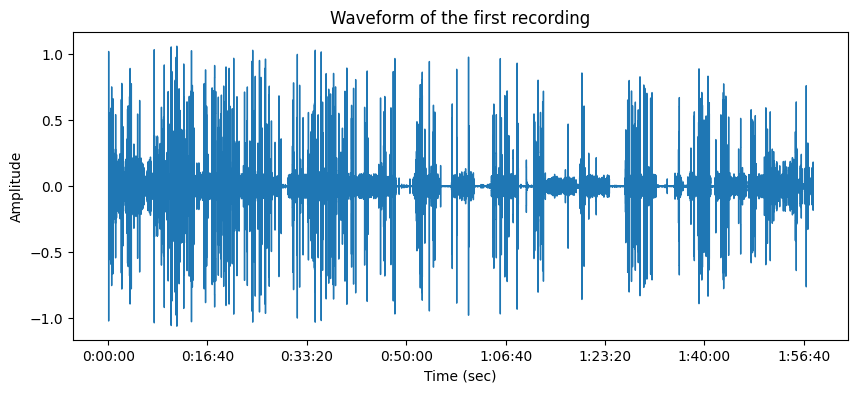

In [4]:
# plot one waveform 
import matplotlib.pyplot as plt
index = 0  # change this to plot a different recording

plt.figure(figsize=(10, 4))
librosa.display.waveshow(waveform[index][0].detach().cpu().numpy(), sr=sampling_rate[0])
plt.title("Waveform of the first recording")
plt.xlabel("Time (sec)")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
### NOT WORKING TODO: FIX FOR LOOP - TOO MUCH MEM
import scipy.signal
import torch
import torch.nn.functional as F

def create_gaussian_filters(n_filters, kernel_size, sample_rate, min_freq=300, max_freq=8000):
    filters = []
    freqs = np.geomspace(min_freq, max_freq, n_filters)
    t = np.linspace(-1, 1, kernel_size)
    
    for f in freqs:
        std = 1.0 / (2 * np.pi * f)
        g = np.exp(-0.5 * (t / std)**2) * np.cos(2 * np.pi * f * t)
        norm = np.sum(np.abs(g))
        if norm == 0 or np.isnan(norm):
            print(f"Skipping filter at f = {f:.2f} Hz (norm = {norm})")
            continue  # or set to a small constant
        filters.append(g / norm)

    filters = np.stack(filters)
    return torch.from_numpy(filters).float().unsqueeze(1)  # (n_filters, 1, kernel_size)

def sliding_windows(x, window_size, hop_size):
    """Slice 1D tensor into overlapping windows."""
    x = x.unfold(0, window_size, hop_size)  # shape: (num_windows, window_size)
    return x

In [ ]:
# Parameters
window_size = 2048
hop_size = 512

# Prepare waveform for conv1d: (batch=1, in_channels=1, time)
waveform_input = waveform[0].unsqueeze(0)  # shape (1, 1, T)

filters = create_gaussian_filters(n_filters=64, kernel_size=1024, sample_rate=sampling_rate[0], min_freq=300, max_freq=4000)  # shape (64, 1, 1024)

# Pad manually if needed
padding = filters.shape[-1] // 2
filtered = F.conv1d(waveform_input, filters, padding=padding)  # shape: (1, 64, T)

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(filters.shape[0]):
    plt.plot(filters[i, 0].detach().cpu().numpy(), alpha=0.6, label=f"Filter {i}" if i % 8 == 0 else "")  # sparsify legend

plt.title("Gaussian Filter Bank")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend(loc="upper right", fontsize=8)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.fft import fft, fftfreq

fs = sampling_rate[0]
n_filters, _, kernel_size = filters.shape
freqs = fftfreq(kernel_size, d=1/fs)

plt.figure(figsize=(12, 6))
for i in range(n_filters):
    fft_vals = np.abs(fft(filters[i, 0].numpy()))
    plt.plot(freqs[:kernel_size//2], fft_vals[:kernel_size//2], alpha=0.6)

plt.title("Frequency Response of Gaussian Filters")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()
